In [1]:
# set AWS credentials file ~/.aws/credentials or load environment variables to load data from Metaflow
%env MLFLOW_TRACKING_URI=http://localhost:5000
%env AWS_ACCESS_KEY_ID=admin
%env AWS_SECRET_ACCESS_KEY=s3secret

env: MLFLOW_TRACKING_URI=http://localhost:5000
env: AWS_ACCESS_KEY_ID=admin
env: AWS_SECRET_ACCESS_KEY=s3secret


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.pipeline import Pipeline
from ml_pipeline.preprocess import add_features, vectorize

In [3]:
train_df = pd.read_csv("./docker/datasets/twitter-train.csv")
test_df = pd.read_csv("./docker/datasets/twitter-test.csv")

add_features(train_df)
add_features(test_df)

# remove duplicates
train_df = train_df.drop_duplicates(subset=['text'])

print(train_df.describe())
train_df.head()

#train_df[train_df.keyword == "wreck"]
#train_df.dtypes
#print(train_df.groupby(["keyword", "target"])["target"].count().tail())
#print(train_df[train_df["id"] == 7772].values)

                 id       target    count.url  count.hashtag  count.reply  \
count   7526.000000  7526.000000  7526.000000    7526.000000  7526.000000   
mean    5440.859155     0.427452     0.624369       0.441005     0.365400   
std     3144.098023     0.494742     0.663534       1.091757     0.722965   
min        1.000000     0.000000     0.000000       0.000000     0.000000   
25%     2720.750000     0.000000     0.000000       0.000000     0.000000   
50%     5406.500000     0.000000     1.000000       0.000000     0.000000   
75%     8154.750000     1.000000     1.000000       0.000000     1.000000   
max    10873.000000     1.000000     4.000000      13.000000     8.000000   

       count.exclamation  count.question   count.caps  has.ellipsis  \
count        7526.000000     7526.000000  7526.000000   7526.000000   
mean            0.154132        0.414696     0.971432      0.127026   
std             0.620707        1.843395     2.044516      0.333025   
min             0.0000

,id,keyword,location,text,target,count.url,count.hashtag,count.reply,count.exclamation,count.question,count.caps,has.ellipsis,count.words,average.word.length
0,1,NaN,NaN,keyword_ Our Deeds are the Reason of this #ear...,1,0,1,0,0,0,1,0,13,4
1,4,NaN,NaN,keyword_ Forest fire near La Ronge Sask. Canada,1,0,0,0,0,0,0,0,7,4
2,5,NaN,NaN,keyword_ All residents asked to 'shelter in pl...,1,0,0,0,0,0,0,0,22,5
3,6,NaN,NaN,"keyword_ 13,000 people receive #wildfires evac...",1,0,1,0,0,0,0,0,9,7
4,7,NaN,NaN,keyword_ Just got sent this photo from Ruby #A...,1,0,2,0,0,0,0,0,16,4


In [4]:
from metaflow import Flow, Step, get_metadata
print("Current metadata provider: %s" % get_metadata())

run = Flow("TrainFlow").latest_successful_run
print("Using run: %s" % str(run))

#Step(f"TrainFlow/{run.id}/start").task.data.vectorizer
best_clf = run.data.best_clf
best_vectorizer = run.data.vectorizer
best_clf["nb"].alpha

Current metadata provider: service@http://localhost:8080
Using run: Run('TrainFlow/43')


0.6

In [5]:
X_train, X_test, y_train, y_test = train_test_split(train_df, train_df['target'], test_size=0.2, random_state=1, stratify=train_df['target'])
print(X_train['target'].value_counts(normalize=True))
print(X_test['target'].value_counts(normalize=True))

0    0.572591
1    0.427409
Name: target, dtype: float64
0    0.572377
1    0.427623
Name: target, dtype: float64


In [6]:
stop_words = ENGLISH_STOP_WORDS.union(['http', 'https'])
vectorizer = CountVectorizer(min_df=3, stop_words=stop_words)
train_vectors = vectorizer.fit(X_train["text"])

In [7]:
train_vectors = vectorize(X_train, vectorizer)
test_vectors = vectorize(X_test, vectorizer)

# df = pd.DataFrame()
# df['.id'] = X_test['id'].values
# df[".text"] = X_test['text'].values
# feature_names = vectorizer.get_feature_names_out()
# for i, col in enumerate(vectorizer.get_feature_names_out()):
#   df[col] = pd.arrays.SparseArray(test_vectors[:, i].toarray().ravel(), fill_value=0)

# for col in extra_features:
#   df[col] = X_test[col].values

# print(df.head())

In [8]:
parameters = {'svc__C': [1e-6, 1e-5, 1e-4, 1e-3]}
pipe = Pipeline([('scale', StandardScaler(with_mean=False)), ('svc', LinearSVC(class_weight='balanced', random_state=1))])
clf_svc = GridSearchCV(pipe, parameters, scoring=["f1", "accuracy"], refit='f1', return_train_score=True, cv=10)

parameters = {'nb__alpha': np.arange(0.1, 1, 0.1)}
pipe = Pipeline([('bin', Binarizer()), ('nb', MultinomialNB())])
clf_nb = GridSearchCV(pipe, parameters, scoring=["f1", "accuracy"], refit='f1', return_train_score=True, cv=10)

# Naive Bayes with binary features a bit better than SVM, this model gets 0.80140 on Kaggle submission
for model in [clf_svc, clf_nb]:
  model.fit(train_vectors, y_train)
  print(model.best_params_)
  print("Train score:", f1_score(y_train, model.predict(train_vectors)))
  print("Test score:", f1_score(y_test, model.predict(test_vectors)))

{'svc__C': 1e-05}
Train score: 0.8468816373817339
Test score: 0.7649700598802395
{'nb__alpha': 0.6}
Train score: 0.8230233510856206
Test score: 0.7722132471728596


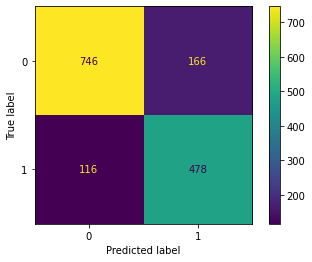

In [9]:
cm = confusion_matrix(clf_nb.predict(test_vectors), y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_nb.classes_)
disp.plot()

In [10]:
submit_vectors = vectorize(test_df, vectorizer)
predictions = clf_nb.predict(submit_vectors)

In [11]:
submit_df = pd.DataFrame({"id": test_df["id"], "target": predictions})
submit_df.to_csv("./docker/datasets/submission.csv", index=False)

In [12]:
#f1_score(y_test, best_clf.predict(test_vectors))

import mlflow
import pickle
#mlflow.set_tracking_uri("http://localhost:5000")
run_id="69409fb8df2946cda4730eff64f2dc95"
logged_model = f'runs:/{run_id}/nb_classifier'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
#f1_score(y_test, loaded_model.predict(test_vectors))

vec_path = mlflow.artifacts.download_artifacts(f"mlflow-artifacts:/1/{run_id}/artifacts/vectorizer-{run_id}.pickle", dst_path=".")
with open(vec_path, 'rb') as handle:
    mlflow_vectorizer = pickle.load(handle)


submit_df = pd.DataFrame({"id": test_df["id"], "target": loaded_model.predict(vectorize(test_df, mlflow_vectorizer))})
submit_df.to_csv("./docker/datasets/submission.csv", index=False)
#f1_score(y_test, loaded_model.predict(vectorize(X_test, mlflow_vectorizer)))

In [13]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
for rm in client.list_registered_models():
    print(rm)

<RegisteredModel: creation_timestamp=1657663065069, description='', last_updated_timestamp=1662760263031, latest_versions=[<ModelVersion: creation_timestamp=1657663065092, current_stage='Staging', description='', last_updated_timestamp=1662760263031, name='nlp-tweets', run_id='f123c7109b6f441a9f37cab2f94dccf9', run_link='', source='mlflow-artifacts:/1/f123c7109b6f441a9f37cab2f94dccf9/artifacts/nb_classifier', status='READY', status_message='', tags={}, user_id='', version='1'>], name='nlp-tweets', tags={}>


In [14]:
# an alternative using pre-trained embeddings: https://www.kaggle.com/code/xiu0714/very-simple-svm-to-reach-0-82